# Music Generator with Recurrent Neural Networks
## Author: EL Firdoussi Aymane
### Reference: [MIT Introduction to Deep Learning]('http://introtodeeplearning.com/')
 In this notebook, we implement the MIT Music genration Lab using the dataset provided in the Github repository of the lab.

 




# Music Generation with RNNs

In this lab, we will explore building a Recurrent Neural Network (RNN) for music generation. We will train a model to learn the patterns in raw sheet music in [ABC notation](https://en.wikipedia.org/wiki/ABC_notation) and then use this model to generate new music.

## 1.1 Dependencies
First, let's download the course repository, install dependencies, and import the relevant packages we'll need for this lab.

In [1]:
# Import Tensorflow 2.0
import tensorflow as tf

# Download and import the MIT Introduction to Deep Learning package
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
#assert len(tf.config.list_physical_devices('GPU')) > 0

## 1.2 Dataset Loading

![Let's Dance!](img/music.gif)

We've gathered a dataset of thousands of Irish folk songs, represented in the ABC notation. Let's download the dataset and inspect it:


In [2]:
# Download the dataset
songs = mdl.lab1.load_training_data()

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


We can easily convert a song in ABC notation to an audio waveform and play it back. Be patient for this conversion to run, it can take some time.

In [ ]:
# Convert the ABC notation to audio file and listen to it
#mdl.lab1.play_song(example_song)
mdl.lab1.play_wav('tmp.wav')


### Finding the set of characters used in the encoding of the songs

In [7]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs)

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print(vocab)
print("There are", len(vocab), "unique characters in the dataset")

['\n', ' ', '!', '"', '#', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|']
There are 83 unique characters in the dataset


## 1.3 Processing the dataset for the learning task

- **Learning task:** We're trying to train a RNN model to learn patterns in ABC music, and then use this model to generate a new piece of music based on this learned information.

- **How ?** To achieve this, we will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step. RNNs maintain an internal state that depends on previously seen elements, so information about all characters seen up until a given moment will be taken into account in generating the prediction.


### Mapping the characters to indexes and vice versa

Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

In [8]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
idx2char = np.array(vocab)

This gives us an integer representation for each character. Observe that the unique characters (i.e., our vocabulary) in the text are mapped as indices from 0 to `len(unique)`. Let's take a peek at this numerical representation of our dataset:

In [9]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [10]:
### Vectorize the songs string ###
def vectorize_string(string):
    vector = np.array([char2idx[char] for char in string])
    return vector

vectorized_songs = vectorize_string(songs_joined)
print(vectorized_songs)

[49 22 13 ... 22 82  2]


We can also look at how the first part of the text is mapped to an integer representation:

In [11]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


### Create training examples and targets

Our next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain `seq_length` characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of `seq_length+1`. Suppose `seq_length` is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [12]:
# Batch definition to create training examples
def get_batch(vectorized_songs, seq_length, batch_size):
    # The length of the vectorized songs string
    n = len(vectorized_songs) - 1

    # Randomly choosing the startng indices for the examples in the training batch
    idx = np.random.choice(n - seq_length, batch_size)

    # Constructing a list of input sequences for the training batch
    input_batch = [vectorized_songs[i : i + seq_length] for i in idx]
    output_batch = [vectorized_songs[i + 1: i + 1 + seq_length] for i in idx]

    # x_batch, y_batch provide the true inputs and targets for network training
    x_batch = np.reshape(input_batch, [batch_size, seq_length])
    y_batch = np.reshape(output_batch, [batch_size, seq_length])

    return x_batch, y_batch

# Perform some simple tests to make sure your batch function is working properly!
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args):
   print("======\n[FAIL] could not pass tests")
else:
   print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


For each of these vectors, each index is processed at a single time step. So, for the input at time step 0, the model receives the index for the first character in the sequence, and tries to predict the index of the next character. At the next timestep, it does the same thing, but the RNN considers the information from the previous step, i.e., its updated state, in addition to the current input.

We can make this concrete by taking a look at how this works over the first several characters in our text:

In [13]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 0 ('\n')
  expected output: 32 ('G')
Step   1
  input: 32 ('G')
  expected output: 27 ('B')
Step   2
  input: 27 ('B')
  expected output: 59 ('d')
Step   3
  input: 59 ('d')
  expected output: 1 (' ')
Step   4
  input: 1 (' ')
  expected output: 62 ('g')


## 1.4 The Recurrent Neural Network (RNN) model

Now we're ready to define and train a RNN model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our RNN using batches of song snippets from our dataset, which we generated in the previous section.

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. The final output of the LSTM is then fed into a fully connected [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character.

As we introduced in the first portion of this lab, we'll be using the Keras API, specifically, [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential), to define the model. Three layers are used to define the model:

* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with `embedding_dim` dimensions.
* [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Our LSTM network, with size `units=rnn_units`.
* [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with `vocab_size` outputs.


<img src="https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_unrolled-01-01.png" alt="Drawing"/>

### Define the RNN model

Now, we will define a function that we will use to actually build the model.

In [14]:
def LSTM(rnn_units):
  return tf.keras.layers.LSTM(
    rnn_units,
    return_sequences=True,
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [15]:
# Defining the RNN model
def build_RNN(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        # Layer 1: modeling indices from 0 to 82 with vectors with dimesion embedding_dim
        tf.keras.layers.Embedding(input_dim = vocab_size,
                                  output_dim = embedding_dim,
                                  batch_input_shape=[batch_size, None]),

        # Layer 2: LSTM
        LSTM(rnn_units),

        # Layer 3: Dense layer
        tf.keras.layers.Dense(units = vocab_size, activation = 'softmax')

    ])

    return model

model = build_RNN(len(vocab), embedding_dim = 256, rnn_units = 1024, batch_size = 32)

### Test out the RNN model

It's always a good idea to run a few simple checks on our model to see that it behaves as expected.  

First, we can use the `Model.summary` function to print out a summary of our model's internal workings. Here we can check the layers in the model, the shape of the output of each of the layers, the batch size, etc.

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 256)           21248     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dense (Dense)               (32, None, 83)            85075     
                                                                 
Total params: 5353299 (20.42 MB)
Trainable params: 5353299 (20.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


----
### Comment on this model:
We transform each index (from 0 to 82) to a vector of size 256 with the embedding technique, and then feed it to LSTM layer (which is the $h$ is our study) which is formed with 1024 (rnn_units) neurons, i.e:
$$ h = W_{xh} x + b $$
where: $x \in \{ 0, .., 82\}^{256}$ (vector of size embedding_dim), and $W_{xh} \in \mathbb{R}^{ 1024 \times 100}$ and $h \in \mathbb{R}^{1024}$. Then we predict the output by feeding $h$ to a dense layer and use the softmax activation function, i.e:
$$ \widehat{y} = softmax(W_{hy} h + c)  $$
where $W_{hy} \in \mathbb{R}^{ 83 \times 1024}$ and $c \in \mathbb{R}^{83}$.

And this is done for every 32 (batch size) samples.

----

We can also quickly check the dimensionality of our output, using a sequence length of 100. Note that the model can be run on inputs of any length.

In [17]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")
print(f"Training labels shape: {y.shape}")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)
Training labels shape: (32, 100)


### Predictions from the untrained model

Let's take a look at what our untrained model is predicting.

To get actual predictions from the model, we sample from the output distribution, which is defined by a `softmax` over our character vocabulary. This will give us actual character indices. This means we are using a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) to sample over the example prediction. This gives a prediction of the next character (specifically its index) at each timestep.

Note here that we sample from this probability distribution, as opposed to simply taking the `argmax`, which can cause the model to get stuck in a loop.

Let's try this sampling out for the first example in the batch.

In [18]:
# We will randomly pick an output sequence from the outputs of the first batch
# pred[0] is of shape (100, 83)
sampled_indices = tf.random.categorical(pred[0], num_samples=1)

# sampled_indices is of shape (100, 1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([16, 37, 77, 51, 31, 41, 69, 72, 65, 24, 79, 33, 75, 56, 36, 28, 63,
       52, 70, 36, 71,  9, 35, 16, 62, 21,  9, 14,  7, 61, 52, 47, 36,  5,
       24, 52, 24, 53, 10, 57, 63, 51, 43, 14, 18, 37, 70, 18, 66,  3, 24,
       11, 73, 20,  1, 23, 61, 76, 48, 18, 58, 42,  5, 18, 65, 40,  6, 44,
       79, 23, 43, 81, 80, 27,  1, 10, 67, 70,  5, 21, 57, 57, 49, 76, 50,
       48, 57, 36, 12, 59, 48, 57,  4,  8, 47, 72, 69, 36, 25, 51])

We can now decode these to see the text predicted by the untrained model:

In [19]:
print("Input: \n", repr("".join(idx2char[x[0]])))

print("\nNext Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 '2/4\nL:1/8\nK:D Major\nFA Ad|B/c/d/B/ AF|GB AF/A/|BE G/F/E/D/|!\nFA Ad|B/c/d/B/ AF|GB A/B/A/G/|FD DE:|!\n'

Next Char Predictions: 
 '4LvZFPnqj=xHtaKCh[oKp-J4g9-2)f[VK\'=[=].bhZR26Lo6k"=/r8 <fuW6cQ\'6jO(Sx<RzyB .lo\'9bbXuYWbK0dWb#,VqnK>Z'


As we can see, the text predicted by the untrained model is pretty nonsensical! How can we do better? We can train the network!

## 1.5 Training the model: loss and training operations

Now it's time to train the model!

At this point, we can think of our next character prediction problem as a standard classification problem. Given the previous state of the RNN, as well as the input at a given time step, we want to predict the class of the next character -- that is, to actually predict the next character.

To train our model on this classification task, we can use a form of the `crossentropy` loss (negative log likelihood loss). Specifically, we will use the [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) loss, as it utilizes integer targets for categorical classification tasks. We will want to compute the loss using the true targets -- the `labels` -- and the predicted targets -- the `logits`.

Let's first compute the loss using our example predictions from the untrained model:

### Loss function:

[`keras.losses.sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) is the cross-entropy loss that takes three arguments:
- **y_true:** which is the class of the true label in $\mathbb{N}$
- **y_pred:** which is the output of the softmax (i.e a vector not a class directly)
- **from_logits:** Whether y_pred is expected to be a logits tensor (containing the values obtained by the softmax). By default, we assume that y_pred encodes a probability distribution.

In [21]:
# Defining the loss function
def compute_loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(y_true = labels, y_pred = logits, from_logits=True)

example_batch_loss = compute_loss(y, pred)
print(f"Prediction shape : {pred.shape}")
print(f"Scalar loss: {example_batch_loss.numpy().mean()}")

Prediction shape : (32, 100, 83)
Scalar loss: 4.418315410614014


## Hyperparameters:
Let's start by defining some hyperparameters for training the model.

In [22]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 3000  # Increase this to train longer
batch_size = 32  # Experiment between 1 and 64
seq_length = 300  # Experiment between 50 and 500
lr = 1e-3 # Learning rate: Experiment between 1e-5 and 1e-1

# Storage of the model
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

### Optimizer and backpropagation

Some optimizers that we can like to try are [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam?version=stable) and [`Adagrad`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad?version=stable).

First, we will instantiate a new model and an optimizer. Then, we will use the [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) method to perform the backpropagation operations.

We will also generate a print-out of the model's progress through training, which will help us easily visualize whether or not we are minimizing the loss.

In [127]:
# Model parameters:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024  # Experiment between 1 and 2048

# Instantiating the model
model = build_RNN(vocab_size, embedding_dim, rnn_units, batch_size)

# Defining an optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate= lr,
    weight_decay=0.5,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name='Adam')

# Decorator: @tf.function is used in TensorFlow to convert
# #Python functions into optimized TensorFlow computational graphs.
@tf.function
def train_step(x, y):
    # Use tf.GradientTape()
    with tf.GradientTape() as tape:
        # Prediction: forward
        y_hat = model(x)

        # loss
        loss = compute_loss(y, y_hat)

        # Compute gradients
        gradients = tape.gradient(loss, model.trainable_variables)

        # Applying the gradients to the optimizer
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        return loss

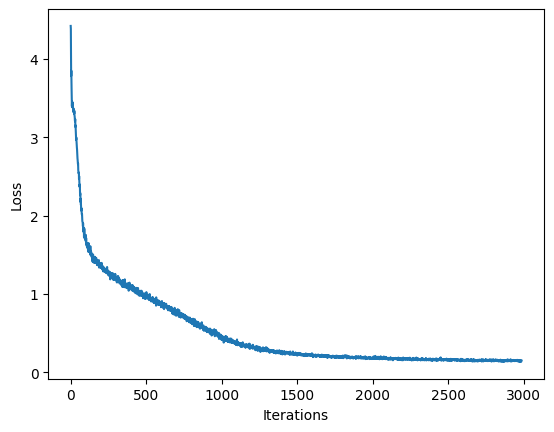

100%|██████████| 3000/3000 [07:01<00:00,  7.12it/s]


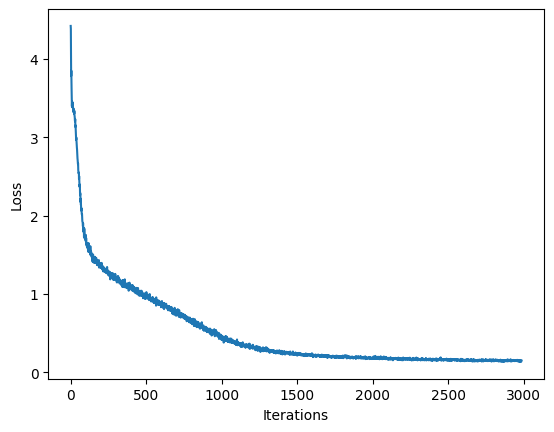

In [128]:
# Training
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):
    # Grabing a batch and propagating it through the network
    x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
    loss = train_step(x_batch, y_batch)

    # Update the progress bar
    history.append(loss.numpy().mean())
    plotter.plot(history)

    # Updating the model with the new weights
    if iter % 100 == 0:
        model.save_weights(checkpoint_prefix)

# Saving the trained model and the weights
model.save_weights(checkpoint_prefix)


In [129]:
print(f"Final loss is {history[-1]}")

Final loss is 0.14717592298984528


## 1.6 Generating music using the RNN model

Now, we can use our trained RNN model to generate some music! When generating music, we'll have to feed the model some sort of seed to get it started (because it can't predict anything without something to start with!).

Once we have a generated seed, we can then iteratively predict each successive character (remember, we are using the ABC representation for our music) using our trained RNN. More specifically, recall that our RNN outputs a `softmax` over possible successive characters. For inference, we iteratively sample from these distributions, and then use our samples to encode a generated song in the ABC format.

Then, all we have to do is write it to a file and listen!

### Loading an existing model
This cell is important because it shows us how we can restore a model that was already trained !

In [32]:
# Rebuilding the model using a batch_size=1
model = build_RNN(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (1, None, 256)            21248     
                                                                 
 lstm_4 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_4 (Dense)             (1, None, 83)             85075     
                                                                 
Total params: 5353299 (20.42 MB)
Trainable params: 5353299 (20.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Notice that we have fed in a fixed `batch_size` of 1 for inference.

### The prediction procedure

Now, we're ready to write the code to generate text in the ABC music format:

* Initialize a "seed" start string and the RNN state, and set the number of characters we want to generate.

* Use the start string and the RNN state to obtain the probability distribution over the next predicted character.

* Sample from multinomial distribution to calculate the index of the predicted character. This predicted character is then used as the next input to the model.

* At each time step, the updated RNN state is fed back into the model, so that it now has more context in making the next prediction. After predicting the next character, the updated RNN states are again fed back into the model, which is how it learns sequence dependencies in the data, as it gets more information from the previous predictions.

![LSTM inference](https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_inference.png)

Complete and experiment with this code block (as well as some of the aspects of network definition and training!), and see how the model performs. How do songs generated after training with a small number of epochs compare to those generated after a longer duration of training?

In [33]:
# Generating a song

def generate_text(model, start_string, generation_length = 1000):
    # Evaluation step (generating ABC text using learned RNN)
    input_eval = vectorize_string(start_string)
    input_eval = tf.expand_dims(input_eval, 0) # shape (1, 1)
    # Empty string to store our results
    text_generated =[]

    # Here batch_size = 1
    model.reset_states()
    tqdm._instances.clear()

    for i in tqdm(range(generation_length)):
        # Forward: it will give a 3-d tensor of shape (1, 1, 83) (first 1: batch_size, second 1: how many inputs we predicted)
        predictions = model(input_eval)

        # Remove the batch dimension: give a shape (1, 83)
        predictions = tf.squeeze(predictions, 0)

        # Taking the maximum of the softmax
        predicted_id = tf.argmax(predictions[0]).numpy()

        # Pass the prediction along with the previous hidden state
        #  as the next inputs to the model
        input_eval = tf.expand_dims([predicted_id], 0)

        # Adding the predicted character to the generated text
        # Hint: consider what format the prediction is in vs. the output
        text_generated.append(idx2char[predicted_id])

    return (start_string + "".join(text_generated))

In [134]:
# Testing
generated_text = generate_text(model, start_string="X", generation_length=1000)
print("\n" + generated_text)

100%|██████████| 1000/1000 [00:10<00:00, 99.04it/s]


X:1/8
K:K:1/8
K:K:1/8
K:K:1/8
K:K:1/8
K:K:1/8
K:K:1/8
K:1/8
K:D Mixolydian
A|FDF A2B|cAd cAG|Ad^c d2e|fed cAG|!
FDF A2B|cAd cAG|Ade fge|ed^c d2:|!
g|fdg fdc|Adc Ade|f3 fed|AB^c dfg|!
a3 g3|fed cAG|Ade fge|ed^c d2:|!

X:28
T:Con Cassidy's
Z: id:dc-jig-22
M:6/8
L:1/8
K:G Major
dc|BAB cBc|dgg d2g|fed cAF|Ggg d2c|!
BAB cBc|dgg d2g|fed cAF|G3 G:|!
Bd|gGG FGG|efg d2c|BA^G Aag|fed efg|!
a2f gfe|fed fga|gfe def|gGG G:|!

X:29
T:Connaught Man's Rambles
Z: id:dc-jig-23
M:6/8
L:1/8
K:D Major
E|F3 AFE|EDB, A,B,D|FEF GFG|ABF AFE|!
F3 AFE|EDB, A,B,D|FEF GFG|BAF D2:|!
e|f2d dcd|edc Bcd|f2d dcd|ABF Ade|!
f2d dcd|edc Bcd|faf gec|dec d2:|!

X:158
T:Tripping Up the Stairs
Z: id:dc-jig-135
M:6/8
L:1/8
K:D Major
E|F3 AFE|EDB, A,B,D|FEF GFG|ABF AFE|!
F3 AFE|EDB, A,B,D|FEF GFG|BAF D2:|!
e|f2d dcd|edc Bcd|f2d dcd|ABF Ade|!
f2d dcd|edc Bcd|faf gec|dec d2:|!

X:158
T:Tripping Up the Stairs
Z: id:dc-jig-135
M:6/8
L:1/8
K:D Major
E|F3 AFE|EDB, A,B,D|FEF GFG|ABF AFE|!
F3 AFE|EDB, A,B,D|FEF GFG|BAF D2:|!
e|f2d dcd

### Play back the generated music!

We can now call a function to convert the ABC format text to an audio file, and then play that back to check out our generated music! Try training longer if the resulting song is not long enough, or re-generating the song!

In [ ]:
## Generating the song
generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
    # Synthesize the waveform from a song
    waveform = mdl.lab1.play_song(song)
    print(waveform)

    if waveform:
        print("Generated song", i)
        ipythondisplay.display(waveform)

This was an example that was generated before.

In [1]:
head = '''X:818
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
'''
final_song = head + '''B|A3B AFDF|A2FD GECE|A3d BdAG|FDD2 EFGE|!
A3B AFDF|A2FD GECE|A3d BdAG|FDD2 EFGE|!
A3B AFDF|A2FD GECE|A3d BdAG|FDD2 EFGE|!
A3B AFDF|A2FD GECE|A3d BdAG|FDD2 EFGE|!
A3B AFDF|A2FD GECE|A3d BdAG|FDD2 EFGE|!
A3B AFDF|A2FD GECE|A3d Bd'''
print(final_song)

X:818
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
B|A3B AFDF|A2FD GECE|A3d BdAG|FDD2 EFGE|!
A3B AFDF|A2FD GECE|A3d BdAG|FDD2 EFGE|!
A3B AFDF|A2FD GECE|A3d BdAG|FDD2 EFGE|!
A3B AFDF|A2FD GECE|A3d BdAG|FDD2 EFGE|!
A3B AFDF|A2FD GECE|A3d BdAG|FDD2 EFGE|!
A3B AFDF|A2FD GECE|A3d Bd


----------